<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg"  width=300, align="right">
<br>
<br>
<br>
<br>
<br>

# **Deep Learning - Image Classification, Keras**
---

Seguindo o modelo apresentado em aula crie com o TensorFlow um classificador de imagens (ver as opções de imagens em *Exercício Selecionado*, abaixo). Adcionalmente ao modelo apresentado você deve incluir:

1. **Modelo e Treinamento**: parâmetros (mais que um) de *Early-Stopping*, e parâmetros e/ou camadas de *DropOut* para reduzir o overfitting.
2. **Data augumentation**: Empregue ao menos 2 funções de **pré-processamento Keras (2)** e ao menos 2 técnicas de **métodos tf.image (2)**. Outras técnicas mais avançadas são opcionais.
3. **Seleção dos hiperparâmetros**. Crie ao menos dois modelos selecionando o de melhor resultado. Uso do Keras Tuner é opcional.





In [ ]:
#@title **Identificação do Grupo**

#@markdown Integrantes do Grupo, nome completo em ordem alfabética (*informe \<RA\>,\<nome\>*)
Aluno1 = '10402412, Diego Oliveira Aluizio' #@param {type:"string"}
Aluno2 = '10396490, Jônatas Garcia de Oliveira' #@param {type:"string"}
Aluno3 = '10403046, Livia Alabarse dos Santos' #@param {type:"string"}
Aluno4 = '10403028, Marina Scabello Martin' #@param {type:"string"}
Aluno5 = '10265432, Pedro Henrique Araujo Farias' #@param {type:"string"}



### **Escolha a opção de Exercício Selecionado**

Faça a seleção aqui: https://docs.google.com/spreadsheets/d/1Y2n0JE94CNhlQzhJudVMEvTYRE5RnuSa/edit?usp=sharing&ouid=102152623479619184236&rtpof=true&sd=true

e informe:

* **Dados**: https://www.cs.toronto.edu/~kriz/cifar.html
* **Classes**: horse, dog
* **Modelo Pré Treinado**: ResNet


# **Resumo**

Neste trabalho, desenvolvemos dois modelos para classificação de imagens em duas classes: *dog* ou *horse*.

O primeiro modelo teve seus hiperparâmetros configurados manualmente, enquanto para o segundo utilizamos Keras Tuner.

Ao final do trabalho, algumas conclusões e observações foram feitas quanto ao desempenho de ambos os modelos.

# **Descrição da Solução**

A solução foi dada nas seguintes etapas:

- Obtenção dos dados
- Seleção de classes específicas
- Divisão em conjuntos de treinamento, validação e teste
- Pré-processamento de dados
 - *Data Augmentation* no conjunto de treinamento
 - Normalização nos conjuntos de validação e teste
- Construção do modelo
 - *Early-Stopping* e *Dropout*
- Treinando o modelo
- Avaliando resultados
- Encontrando hiperparâmetros com Keras Tuner
- Treinando o modelo
- Avaliando resultados
- Comparação dos resultados



# **Implementação**

Para iniciar a implementação, primeiro vamos importar algumas bibliotecas utilizadas ao longo deste *notebook*.



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation

## **Carregando dados**

Vamos carregar as imagens e labels de treinamento e teste por meio de `cifar10.load_data()`.

O **CIFAR-10** é um *dataset* com 60000 imagens divididas em 10 classes, totalizando 6000 imagens para cada classe: 5000 para treinamento e 1000 para teste.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Formato do x_train:", x_train.shape)
print("Formato do y_train:", y_train.shape)
print("Formato do x_test:", x_test.shape)
print("Formato do y_test:", y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Formato do x_train: (50000, 32, 32, 3)
Formato do y_train: (50000, 1)
Formato do x_test: (10000, 32, 32, 3)
Formato do y_test: (10000, 1)


## **Filtrando classes**

Estamos particularmente interessados nas classes *dog* e *horse* e, portanto, filtraremos os dados para utilizar somente essas classes no treinamento dos modelos:

In [3]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

selected_classes = [classes.index('dog'), classes.index('horse')]

def filter_classes(x, y, classes):
  mask = np.isin(y, classes).flatten()
  x_filtered = x[mask]
  y_filtered = y[mask]
  return x_filtered, y_filtered

x_train_filtered, y_train_filtered = filter_classes(x_train, y_train, selected_classes)
x_test_filtered, y_test_filtered = filter_classes(x_test, y_test, selected_classes)

label_map = {5: 0, 7: 1}
y_train_mapped = np.vectorize(label_map.get)(y_train_filtered)
y_test_mapped = np.vectorize(label_map.get)(y_test_filtered)

print("Formato do x_train filtrado:", x_train_filtered.shape)
print("Formato do y_train mapeado:", y_train_mapped.shape)
print("Classes únicas no treino:", np.unique(y_train_mapped))

Formato do x_train filtrado: (10000, 32, 32, 3)
Formato do y_train mapeado: (10000, 1)
Classes únicas no treino: [0 1]


Note que o número de imagens no conjunto de treinamento é de 10000, pois, sendo 5000 imagens de treinamento para cada classe, teremos 5000 imagens da classe *dog* e 5000 imagens da classe *horse* para treinamento.

## **Definindo conjuntos de treinamento e validação**

Dividiremos o conjunto de 10000 imagens em dois:
- Treinamento: 8000 imagens (80%)
- Validação: 2000 imagens (20%)

`stratify=y_train_mapped` garante que as imagens serão balanceadamente distribuídas entre os conjuntos de *dog* e *horse*.

In [4]:
from sklearn.model_selection import train_test_split

x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train_filtered,
    y_train_mapped,
    test_size=0.2,
    stratify=y_train_mapped,
    random_state=1234
)

print("Treino:", x_train_split.shape, y_train_split.shape)
print("Validação:", x_val.shape, y_val.shape)

Treino: (8000, 32, 32, 3) (8000, 1)
Validação: (2000, 32, 32, 3) (2000, 1)


## ***Data Augmentation***

Essa é uma técnica para aumentar a generalização do modelo, ou seja, evitar *overfitting*, através de alterações às imagens do conjunto de treinamento.

Para isso, constrói-se um *pipeline* de metodos e funções aplicadas aos dados.

### **Funções de pré-processamento Keras**

Aplicaremos algumas funções de pré-processamento ao conjunto de treinamento:
- `Rescaling(1./255)`: Normaliza os pixels para o intervalo `[0,1]`
- `RandomFlip("horizontal")`: Gira a imagem horizontalmente, de modo aleatório
- `RandomRotation(0.1)`: Rotaciona aleatoriamente a imagem

In [5]:
keras_augment = Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
])

### **Métodos `tf.image`**

Ao conjunto de treinamento, serão aplicados os seguintes métodos:
- `random_brightness`: Altera o brilho da imagem aleatoriamente
- `random_contrast`: Altera o contraste da imagem aleatoriamente
- `flip_left_right`: A imagem é girada aleatoriamente (semelhante à função `RandomFlip`)

In [6]:
def tf_image_augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_flip_left_right(image)
    return image, label

### ***Data Augmentation Pipeline***

Aplica-se o *pipeline* somente ao conjunto de treinamento.

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_split, y_train_split))

train_dataset = (
    train_dataset.shuffle(1000)
    .map(lambda x, y: (keras_augment(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .map(tf_image_augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
    .cache()
    )

### **Normalização dos demais conjuntos**

Ainda que o *pipeline* de *data augmentation* não seja aplicado aos conjuntos de validação e teste, é necessário normalizá-los para o intervalo `[0,1]`.

In [8]:
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

val_dataset = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .map(normalize).batch(32).prefetch(tf.data.AUTOTUNE)
    .cache()
    )

test_dataset = (
    tf.data.Dataset.from_tensor_slices((x_test_filtered, y_test_mapped))
    .map(normalize).batch(32).prefetch(tf.data.AUTOTUNE)
    .cache()
    )

## **Funções para avaliação de resultados**

Essas funções serão úteis ao longo do treinamento e validação dos resultados dos modelos.

### **Avaliação de treinamento do modelo**

In [9]:
def eval_model(model, model_hist, val_ds):
    acc = model_hist.history['accuracy']
    val_acc = model_hist.history['val_accuracy']
    loss = model_hist.history['loss']
    val_loss = model_hist.history['val_loss']

    epochs_range = range(len(model_hist.history['loss']))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
    plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
    plt.legend(loc='lower right')
    plt.title('Acurácia de Treinamento e Validação')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perda de Treinamento')
    plt.plot(epochs_range, val_loss, label='Perda de Validação')
    plt.legend(loc='upper right')
    plt.title('Perda de Treinamento e Validação')
    plt.show()

    # Avaliar o modelo
    evaluation = model.evaluate(val_ds)
    print(f"Acurácia no conjunto de validação: {evaluation[1]:.4f}")

### **Realiza uma predição e avalia seus resultados**

In [10]:
def make_pred(model, dataset, class_names, num_images=5):
    all_images = []
    all_labels = []

    for images, labels in dataset.unbatch().take(500):
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())

    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    random_indices = np.random.choice(len(all_images), size=num_images, replace=False)

    plt.figure(figsize=(10, 2 * num_images))

    for i, idx in enumerate(random_indices):
        img = all_images[idx]
        label = all_labels[idx]

        prediction = model.predict(tf.expand_dims(img, 0), verbose=0)[0][0]
        predicted_class = int(prediction >= 0.5)
        actual_class = int(label[0])

        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(img)
        plt.title(f"Real: {class_names[actual_class]}")
        plt.axis('off')

        plt.subplot(num_images, 2, i * 2 + 2)
        bar_colors = ['green' if j == actual_class else 'red' for j in range(2)]
        plt.bar(class_names, [1 - prediction, prediction], color=bar_colors)
        plt.title(f"Previsão: {class_names[predicted_class]} ({prediction:.2f})")
        plt.ylim([0, 1])

    plt.tight_layout()
    plt.show()

## **Modelo 1**

O modelo apresenta saída final com 1 unidade e função de ativação `sigmoid`, pois estamos efetivamente realizando uma classificação binária (*dog* x *horse*).

Foram adicionadas camadas de *Dropout* para reduzir o *overfitting*.

In [11]:
first_model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Dropout(0.2), # camada de dropout

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),

    layers.Dropout(0.5), # camada de dropout

    layers.Dense(1, activation='sigmoid')
])

first_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

first_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,913 (605.13 KB)

 Trainable params: 154,913 (605.13 KB)

 Non-trainable params: 0 (0.00 B)

### ***Early-Stopping***

Para reduzir ainda mais o *overfitting*, aplicamos um *callback** de *early-stopping* com os seguintes parâmetros:

- *monitor*: Indica qual métrica será observada, no caso, `val_loss`
- *patience*: Número de *epochs* toleradas sem melhora
- *restore_best_weights*: Restaura os pesos da melhor *epoch* obtida ao final

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

### **Treinamento do modelo**

Utilizamos a função `fit` para treinar o modelo, indicando os conjuntos de treinamento e validação, número de *epochs* e os parâmetros de *early-stopping*.

In [13]:
first_history = first_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.6333 - loss: 0.6290 - val_accuracy: 0.7680 - val_loss: 0.4902
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7487 - loss: 0.5184 - val_accuracy: 0.8005 - val_loss: 0.4330
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7862 - loss: 0.4632 - val_accuracy: 0.8180 - val_loss: 0.4061
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7967 - loss: 0.4350 - val_accuracy: 0.8370 - val_loss: 0.3817
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.8174 - loss: 0.4060 - val_accuracy: 0.8420 - val_loss: 0.3707
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8250 - loss: 0.3874 - val_accuracy: 0.8495 - val_loss: 0.3483
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.8343 - loss: 0.3664 - val_accuracy: 0.8560 - val_loss: 0.3465
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.8504 - loss: 0.3468 - 

### **Avaliando treinamento do modelo**

Utilizamos a função `eval_model` para avaliar as acurácias do modelo ao longo de seu treinamento, observando sua curva de aprendizagem.

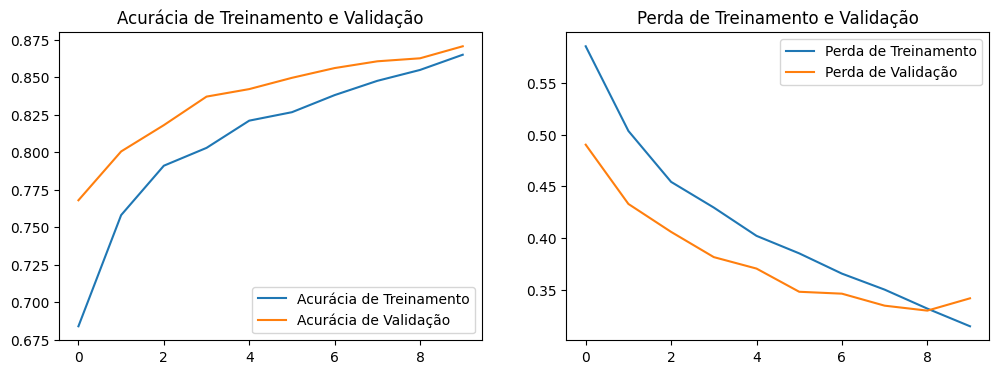

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8604 - loss: 0.3566
Acurácia no conjunto de validação: 0.8625


In [14]:
eval_model(first_model, first_history, val_dataset)

A acurácia do modelo no conjunto de validação foi de 86.25%, o que corresponde a um ótimo valor. Nota-se também que a acurácia de treinamento não ultrapassa a acurácia de validação, indicando **baixo *overfitting***.

### **Fazendo predições**

Aqui, finalmente utilizaremos o conjunto de testes para testar nosso modelo.

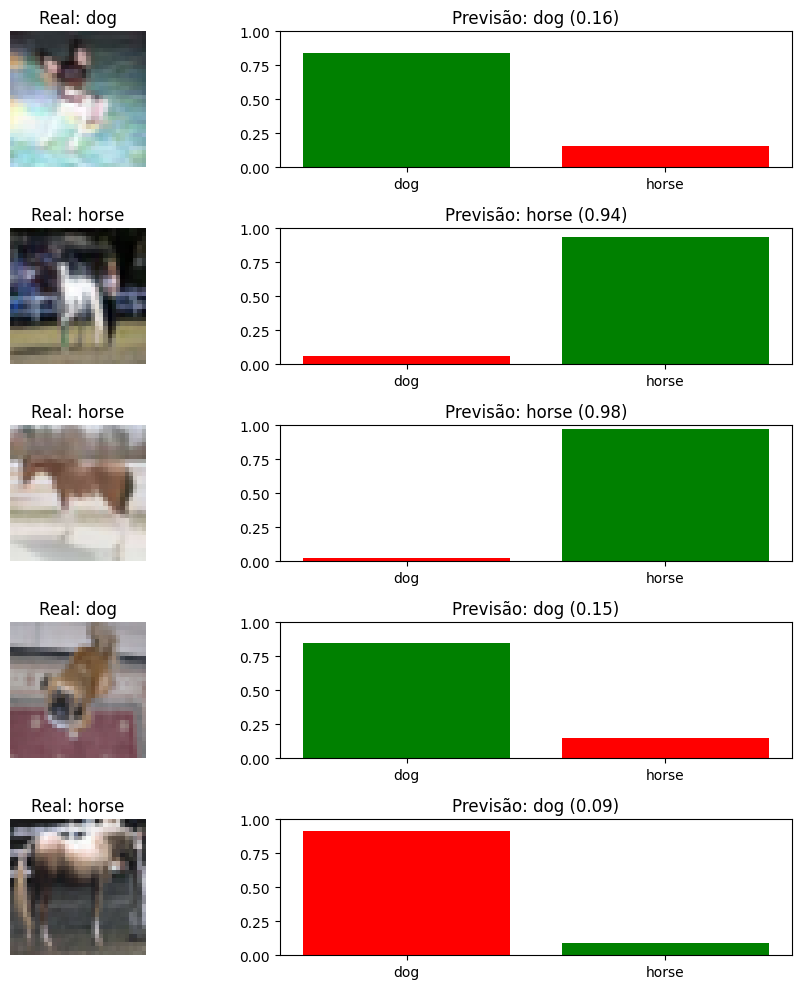

In [15]:
class_names = ['dog', 'horse']
make_pred(first_model, test_dataset, class_names, num_images=5)

## **Modelo 2**

Para o segundo modelo, utilizaremos o **Keras Tuner**, de modo a selecionar os melhores hiperparâmetros.

In [16]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


### **Exploração de Hiperparâmetros**

Na célula abaixo, definimos a função `build_model(hp)`, a qual instanciará um modelo com algumas camadas fixas e outras variáveis, nas quais hiperparâmetros como número de camadas densas, número de neurônios, taxa de *dropout* e taxa de aprendizado serão explorados.

In [17]:
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())

    for i in range(hp.Int('num_dense_layers', 1, 3)):
        units = hp.Int(f'units_{i}', min_value=64, max_value=256, step=64)
        model.add(layers.Dense(units=units, activation='relu'))
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

    model.add(layers.Dense(1, activation='sigmoid'))

    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

Em seguida, criamos um *tuner* que aplicará a função `build_model` e procurará pelos melhores hiperparâmetros para o modelo utilizando o `RandomSearch`.

In [18]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='dog_horse_layers_tuning'
)

tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])

Trial 10 Complete [00h 00m 56s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.8585000038146973
Total elapsed time: 00h 23m 12s


### **Identificando hiperparâmetros selecionados**

In [19]:
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Melhores hiperparâmetros encontrados:")
print(f"Número de camadas densas: {best_hp.get('num_dense_layers')}")
for i in range(best_hp.get('num_dense_layers')):
    print(f"  Camada {i+1} - unidades: {best_hp.get(f'units_{i}')}, dropout: {best_hp.get(f'dropout_{i}')}")
print(f"Taxa de aprendizado: {best_hp.get('learning_rate')}")

tuned = tuner.hypermodel.build(best_hp)

Melhores hiperparâmetros encontrados:
Número de camadas densas: 1
  Camada 1 - unidades: 192, dropout: 0.4
Taxa de aprendizado: 0.001


### **Treinamento do modelo tunado**

In [20]:
tuned_history = tuned.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
    )

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.6456 - loss: 0.6203 - val_accuracy: 0.7860 - val_loss: 0.4624
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.7681 - loss: 0.4848 - val_accuracy: 0.8180 - val_loss: 0.4076
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.8045 - loss: 0.4342 - val_accuracy: 0.8340 - val_loss: 0.3840
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8260 - loss: 0.3961 - val_accuracy: 0.8435 - val_loss: 0.3586
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8415 - loss: 0.3609 - val_accuracy: 0.8395 - val_loss: 0.3593
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.8508 - loss: 0.3396 - val_accuracy: 0.8440 - val_loss: 0.3657
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8705 - loss: 0.3062 - val_accuracy: 0.8380 - val_loss: 0.3834


### **Avaliação do treinamento do modelo**

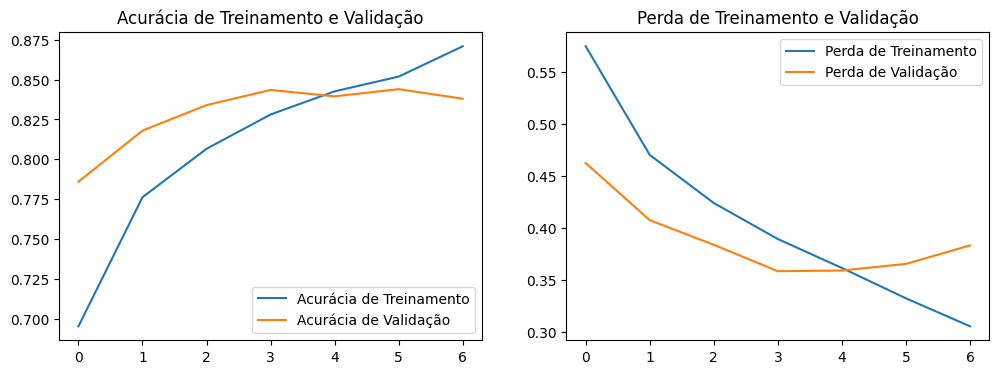

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8313 - loss: 0.3805
Acurácia no conjunto de validação: 0.8435


In [21]:
eval_model(tuned, tuned_history, val_dataset)

Observa-se que o modelo só foi executado por 7 *epochs*, e depois parou abruptamente devido o *early-stopping* configurado.

Sua acurácia foi de 84.35%, **menor** menor do que a acurácia do modelo cujos hiperparâmetros foram configurados manualmente. Além disso, sua curva de aprendizagem indica maior tendência de *overfitting*.

Comentaremos mais sobre na seção de discussões de resultados.

### **Fazendo predições**

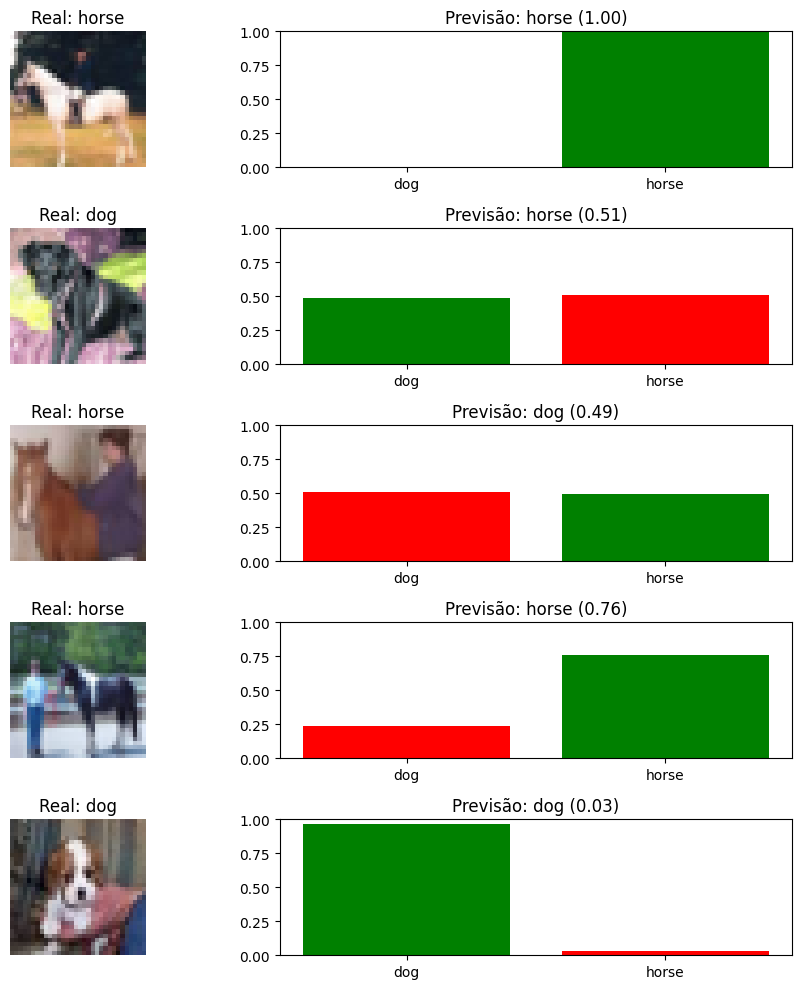

In [23]:
make_pred(tuned, test_dataset, class_names, num_images=5)

# **Resultados**

Ao longo desse trabalho, construímos dois modelos para classificação de imagens entre as classes *horse* e *dog*.

A expectativa era de que o segundo modelo, no qual se utilizou *Keras Tuner* para obter seus hiperparâmetros, tivesse melhor desempenho se comparado ao primeiro modelo, o que não ocorreu.

Um dos motivos pode ser o método utilizado no *tuning*: `RandomSearch`. Por ser aleatório, ou seja, não segue uma heurística ou algoritmo específico, a amostra de hiperparâmetros pode não ter sido satisfatória.

Além disso, por ser um modelo simples, foram realizadas poucas iterações. Talvez com modelos mais complexos, que exigem mais *epochs* para um treinamento adequado, o modelo ajustado manualmente desempenhe pior do que o ajustado pelo Keras Tuner.

Ainda assim, ambos os modelos apresentaram acuracidade acima de 0.8 e baixa tendência a *overfitting*.


# **Referências**

1. SIGMOIDAL. Reduzindo Overfitting com Data Augmentation. Disponível em: https://sigmoidal.ai/reduzindo-overfitting-com-data-augmentation/. Acesso em: 20 maio 2025.

2. TENSORFLOW. Classificação de imagens. Disponível em: https://www.tensorflow.org/tutorials/images/classification?hl=pt-br. Acesso em: 20 maio 2025.

3. SIGMOIDAL. Reduzindo Overfitting com Data Augmentation. Disponível em: https://sigmoidal.ai/reduzindo-overfitting-com-data-augmentation/. Acesso em: 20 maio 2025.
(Observação: link repetido do item 1.)

4. ROZ, Vinicius Queiroz. Using Keras Tuner to find the best parameters for your neural network model. Medium, 2021. Disponível em: https://medium.com/@viniciusqroz/using-keras-tuner-to-find-the-best-parameters-for-your-neural-network-model-2dc02e0a1203. Acesso em: 20 maio 2025.

5. GEEKSFORGEEKS. CIFAR-10 Image Classification in TensorFlow. Disponível em: https://www.geeksforgeeks.org/cifar-10-image-classification-in-tensorflow/. Acesso em: 20 maio 2025.

6. JAN, Amy. Tensorflow CIFAR10 CNN Tutorial. Kaggle, 2022. Disponível em: https://www.kaggle.com/code/amyjang/tensorflow-cifar10-cnn-tutorial. Acesso em: 20 maio 2025.

7. DIGITALOCEAN. Hyperparameter Optimization with Keras Tuner. DigitalOcean Community, 2021. Disponível em: https://www.digitalocean.com/community/tutorials/hyperparameter-optimization-with-keras-tuner. Acesso em: 20 maio 2025.

---

In [ ]:
#@title **Avaliação**
Resumo = 5 #@param {type:"slider", min:0, max:10, step:1}

Descricao_solucao = 7 #@param {type:"slider", min:0, max:10, step:1}

Implementacao = 9 #@param {type:"slider", min:0, max:10, step:1}

Resultados = 6 #@param {type:"slider", min:0, max:10, step:1}

Referencias = 7 #@param {type:"slider", min:0, max:10, step:1}

Geral = 7 #@param {type:"slider", min:0, max:10, step:1}








In [ ]:
#@title **Nota Final**
nota = Resumo + Descricao_solucao + Implementacao + Resultados + Referencias + Geral

nota = nota / 6

print(f'Nota final do trabalho {nota :.1f}')

import numpy as np
import pandas as pd

alunos = pd.DataFrame()

lista_tia = []
lista_nome = []

for i in range(1,6):
  exec("if Aluno" + str(i) + " !='None':  lista = Aluno" + str(i) + ".split(','); lista_tia.append(lista[0]); lista_nome.append(lista[1].upper())")

alunos['tia'] = lista_tia
alunos['nome'] = lista_nome
alunos['nota'] = np.round(nota,1)
print()
display(alunos)

Nota final do trabalho 7.7



,tia,nome,nota
0,1115665,ADRIANA FUJITA,7.7
1,1115677,DANIEL HENRIQUE,7.7
